<a href="https://colab.research.google.com/github/Paul-locatelli/projet-detection-avions-paul-omar/blob/main/Class_Det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce projet, l’objectif est de détecter des avions sur des images (localiser les bounding boxes) puis de classifier chaque avion détecté dans une classe A1 à A20, et de générer un fichier de prédiction au format JSON imposé par l’évaluateur (teacher validator).

Avant d’arriver à la solution finale, plusieurs approches ont été testées :

1) Premiers essais : classification seule (sans détection fiable)

Nous avons d’abord tenté une classification directe avec des architectures comme ResNet18, puis ResNet50, en utilisant des images ou des crops.

Problème principal : sans une extraction correcte des avions (crops fiables), la classification devient incohérente → scores très faibles, parfois proches de 0 sur l’évaluation finale.

2) Tentatives YOLO (YOLOv5 / YOLOv8)

Nous avons envisagé des pipelines basés sur YOLOv5 et YOLOv8 pour la détection.

Problème rencontré : notre dataset est annoté en XML Pascal VOC (pas en labels YOLO .txt), donc il fallait une conversion et une structure rigoureuse.

De plus, certaines difficultés sur l’organisation des splits et la cohérence des dossiers ont rendu cette piste moins stable dans notre contexte.

3) Problèmes de dataset et de split (80/10/10 + k-fold)

Nous avons voulu mettre en place un split 80/10/10 et même réfléchir à du k-fold.

Erreurs majeures rencontrées :

confusion sur les noms de dossiers (train/val/test vs train1/val0/test1),

risque de “mauvais split” (mauvais appariement image/XML),

et surtout : attention aux fuites (leakage) si on split au niveau des crops plutôt qu’au niveau image.

Architecture retenue : pipeline 2 étages (détection + classification)

La solution finale repose sur un pipeline en deux étapes :

Détection (Faster R-CNN)

Modèle : Faster R-CNN ResNet50-FPN

Rôle : produire des bounding boxes candidates (avions) avec des scores de confiance

Post-traitement : seuil de confiance, NMS, filtrage taille minimale, padding optionnel

Classification sur crop (ResNet50)

Pour chaque box détectée, on découpe (crop) l’image.

Un classifieur ResNet50 prédit la classe A1…A20.

Le résultat final associe une classe à chaque box.

Le JSON final respecte strictement le format demandé :

clé = nom du fichier image

valeur = liste d’objets {class, coordinates}

Évolution des performances : modèle ~52% puis modèle ~66%
Modèle intermédiaire (~52% Overall F1)

Le premier pipeline 2 étages stable a permis d’obtenir environ :

une détection solide (F1 élevé côté localisation),

mais une classification encore limitée, due à :

crops pas toujours optimaux (padding/filtrage),

hyperparamètres (seuils, NMS) pas encore bien réglés,

classifieur pas encore optimal.

Modèle amélioré (~66% Overall F1 — meilleur score obtenu)

Ensuite, nous avons amélioré :

le couplage détection → crop (meilleure qualité des crops),

le post-traitement (seuil, NMS, taille minimale, padding),

l’utilisation du meilleur checkpoint pour le classifieur,

et la génération du JSON final (sans erreurs de format).

Ce modèle atteint environ :

Overall F1 ≈ 0.6689

Detection F1 ≈ 0.8880

Classification F1 ≈ 0.7533

In [ ]:
!pip -q install torch torchvision torchaudio scikit-learn pandas pillow



Ce notebook utilise plusieurs bibliothèques Python nécessaires à l’apprentissage automatique et à l’analyse de données.
L’étape d’installation suivante permet de s’assurer que tous les outils requis sont disponibles avant l’exécution du code.

PyTorch (torch, torchvision, torchaudio) est utilisé pour concevoir, entraîner et exécuter des modèles de machine learning.

Scikit-learn est utilisé pour le prétraitement des données, la séparation des jeux de données (entraînement, validation, test) et l’évaluation des modèles.

Pandas permet de charger, structurer et manipuler les jeux de données.

Pillow est utilisé pour le chargement et le prétraitement des images.

Installer ces dépendances dès le début garantit le bon fonctionnement du notebook et sa reproductibilité dans un environnement propre comme Google Colab.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

PROJECT_DIR = "/content/drive/MyDrive/ia_projet"
SPLIT_ROOT  = f"{PROJECT_DIR}/data/split1n"
print("PROJECT_DIR exists:", __import__("os").path.exists(PROJECT_DIR))
print("SPLIT_ROOT exists :", __import__("os").path.exists(SPLIT_ROOT))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_DIR exists: True
SPLIT_ROOT exists : True


On commence par connecter le notebook à Google Drive afin d’accéder aux fichiers du projet stockés en ligne.
Nous définissons ensuite le dossier principal du projet dans la variable PROJECT_DIR, qui regroupe l’ensemble des données, scripts et résultats utilisés.

Nous définissons également le dossier SPLIT_ROOT, qui correspond à l’emplacement des jeux de données prétraités et organisés en différents sous-ensembles (entraînement, validation et test).

Enfin, nous vérifions que les chemins définis existent bien dans Google Drive. Cette étape permet de s’assurer que l’environnement de travail est correctement configuré et d’éviter des erreurs liées à des chemins inexistants ou mal définis.

In [ ]:
import os, glob

def count_images(root):
    exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG")
    total = 0
    for e in exts:
        total += len(glob.glob(os.path.join(root, "**", e), recursive=True))
    return total

def best_dir_for(split_root, key):
    cands = []
    for dirpath, dirnames, filenames in os.walk(split_root):
        base = os.path.basename(dirpath).lower()
        if key in base:
            n = count_images(dirpath)
            if n > 0:
                cands.append((n, dirpath))
    cands.sort(reverse=True)
    return cands[0] if cands else None

best_train = best_dir_for(SPLIT_ROOT, "train")
best_val   = best_dir_for(SPLIT_ROOT, "val")
best_test  = best_dir_for(SPLIT_ROOT, "test")

print("best_train:", best_train)
print("best_val  :", best_val)
print("best_test :", best_test)
print("TOTAL images in split root:", count_images(SPLIT_ROOT))

assert best_train and best_val and best_test, "Couldn't locate train/val/test dirs with images."
train_dir, val_dir, test_dir = best_train[1], best_val[1], best_test[1]
print("\nUSING:")
print("train_dir:", train_dir, "->", count_images(train_dir))
print("val_dir  :", val_dir,   "->", count_images(val_dir))
print("test_dir :", test_dir,  "->", count_images(test_dir))


best_train: (6290, '/content/drive/MyDrive/ia_projet/data/split1n/split1n/train1')
best_val  : (778, '/content/drive/MyDrive/ia_projet/data/split1n/split1n/val0')
best_test : (802, '/content/drive/MyDrive/ia_projet/data/split1n/split1n/test1')
TOTAL images in split root: 7870

USING:
train_dir: /content/drive/MyDrive/ia_projet/data/split1n/split1n/train1 -> 6290
val_dir  : /content/drive/MyDrive/ia_projet/data/split1n/split1n/val0 -> 778
test_dir : /content/drive/MyDrive/ia_projet/data/split1n/split1n/test1 -> 802


On met en place des fonctions permettant de parcourir l’arborescence du projet afin d’identifier automatiquement les dossiers contenant les images.

On commence par compter le nombre total d’images présentes dans un dossier donné, en prenant en compte les principaux formats d’images courants (JPG, JPEG, PNG). Cette étape permet de vérifier que les dossiers contiennent bien des données exploitables.

Ensuite, on recherche, à partir du dossier racine des données, les sous-dossiers correspondant aux jeux d’entraînement, de validation et de test. Pour chaque type de jeu de données, on sélectionne automatiquement le dossier contenant le plus grand nombre d’images, afin de garantir l’utilisation du jeu de données le plus complet.

Enfin, on affiche les dossiers retenus ainsi que le nombre d’images qu’ils contiennent, et on vérifie que les trois ensembles (entraînement, validation et test) ont bien été identifiés. Cette automatisation permet de rendre le notebook plus robuste face aux variations d’organisation des données.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

tf_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

tf_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_base = datasets.ImageFolder(train_dir, transform=tf_train)
classes = train_base.classes
class_to_idx = train_base.class_to_idx
num_classes = len(classes)

print("num_classes:", num_classes)
print("classes:", classes)

class FixedImageFolder(Dataset):
    def __init__(self, root, class_to_idx, transform=None):
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.samples = []
        exts = (".jpg",".jpeg",".png",".JPG",".JPEG",".PNG")
        for cls in sorted(os.listdir(root)):
            cls_path = os.path.join(root, cls)
            if not os.path.isdir(cls_path):
                continue
            if cls not in class_to_idx:
                continue
            for dirpath, _, filenames in os.walk(cls_path):
                for fn in filenames:
                    if fn.endswith(exts):
                        self.samples.append((os.path.join(dirpath, fn), class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, y = self.samples[i]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y

val_ds  = FixedImageFolder(val_dir,  class_to_idx, transform=tf_eval)
test_ds = FixedImageFolder(test_dir, class_to_idx, transform=tf_eval)

print("train samples:", len(train_base))
print("val samples  :", len(val_ds))
print("test samples :", len(test_ds))

train_loader = DataLoader(train_base, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,    batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


num_classes: 20
classes: ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']
train samples: 6290
val samples  : 778
test samples : 802


On commence par définir les transformations appliquées aux images.
Pour le jeu d’entraînement, on applique des opérations de redimensionnement et d’augmentation de données (rotation et retournement horizontal) afin d’améliorer la capacité de généralisation du modèle.
Pour les jeux de validation et de test, on applique uniquement un redimensionnement, afin d’évaluer les performances du modèle sur des données non modifiées.

On charge ensuite le jeu d’entraînement à l’aide de ImageFolder, ce qui nous permet d’extraire automatiquement la liste des classes et leur correspondance numérique. Cette correspondance est conservée afin de garantir une cohérence des étiquettes entre les différents jeux de données.

Nous définissons ensuite une classe personnalisée de type Dataset permettant de charger les jeux de validation et de test tout en utilisant exactement la même association classe–indice que pour l’entraînement. Cette étape est essentielle pour éviter toute incohérence dans l’apprentissage et l’évaluation du modèle.

On affiche ensuite le nombre total de classes ainsi que le nombre d’images présentes dans chaque jeu de données, ce qui permet de vérifier la répartition des données.

Enfin, nous créons les DataLoader pour les jeux d’entraînement, de validation et de test. Ces objets permettent de charger les données par lots, d’optimiser les performances lors de l’entraînement et de faciliter l’itération sur les données pendant l’apprentissage et l’évaluation du modèle.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()
print("device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, num_classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def set_backbone_trainable(m, trainable):
    for name, p in m.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = trainable

def run_epoch(loader, optimizer=None, train=True):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return total_loss/max(total,1), correct/max(total,1)

best_path = "/content/best_resnet18_crops_split_clean.pth"
best_val = -1.0

# Frozen phase
set_backbone_trainable(model, False)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-2)

for e in range(1, 4):
    tr_loss, tr_acc = run_epoch(train_loader, optimizer, True)
    va_loss, va_acc = run_epoch(val_loader,   None, False)
    print(f"[FROZEN] {e}/3 tr_acc={tr_acc:.4f} va_acc={va_acc:.4f}")
    if va_acc > best_val:
        best_val = va_acc
        torch.save({"model": model.state_dict(), "classes": classes, "class_to_idx": class_to_idx}, best_path)

# Unfrozen phase
set_backbone_trainable(model, True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

for e in range(1, 11):
    tr_loss, tr_acc = run_epoch(train_loader, optimizer, True)
    va_loss, va_acc = run_epoch(val_loader,   None, False)
    print(f"[UNFROZEN] {e}/10 tr_acc={tr_acc:.4f} va_acc={va_acc:.4f}")
    if va_acc > best_val:
        best_val = va_acc
        torch.save({"model": model.state_dict(), "classes": classes, "class_to_idx": class_to_idx}, best_path)

print("Saved best:", best_path, "best_val:", best_val)


device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


KeyboardInterrupt: 

On commence par détecter automatiquement si un GPU est disponible afin d’accélérer les calculs, puis on libère la mémoire inutile (RAM et mémoire GPU) pour éviter des erreurs liées au manque de ressources.

Nous utilisons ensuite un modèle ResNet-18 pré-entraîné. L’intérêt du pré-entraînement est de partir d’un réseau qui a déjà appris des caractéristiques générales utiles (bords, textures, formes), ce qui améliore souvent les performances et réduit le temps d’entraînement.
On remplace la dernière couche du modèle (la tête de classification) afin qu’elle produise un score pour chacune de nos classes. On ajoute également un Dropout pour limiter le surapprentissage.

On définit la fonction de perte CrossEntropyLoss, adaptée à la classification multi-classes, et on applique un label smoothing pour rendre l’apprentissage plus robuste aux erreurs d’étiquetage et réduire l’excès de confiance du modèle.

On met en place une fonction run_epoch qui exécute une époque complète sur un DataLoader, soit en mode entraînement (calcul du gradient et mise à jour des poids), soit en mode évaluation (sans mise à jour). On mesure à chaque époque la perte moyenne et la précision.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        out = model(x)
        pred = out.argmax(1).cpu().numpy()
        y_pred.append(pred)
        y_true.append(y.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("TEST accuracy:", (y_true == y_pred).mean())
print(classification_report(y_true, y_pred, target_names=classes, digits=4, zero_division=0))

prec, rec, f1, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(num_classes), average=None, zero_division=0
)

df = pd.DataFrame({"class": classes, "precision": prec, "recall": rec, "f1": f1, "support": sup})
display(df.sort_values("f1"))

plt.figure(figsize=(8,5))
plt.boxplot([df["precision"], df["recall"], df["f1"]], tick_labels=["Precision","Recall","F1"])
plt.ylim(0,1)
plt.grid(True, axis="y")
plt.title("Distribution des scores par classe (TEST)")
plt.show()

cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion (TEST)")
plt.colorbar()
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/content/best_resnet18_crops_split_clean.pth'

On charge d’abord le meilleur modèle sauvegardé (celui qui a obtenu la meilleure performance sur le jeu de validation), puis on remet ses poids dans le réseau et on passe le modèle en mode évaluation. Cela garantit que l’on évalue exactement la version la plus performante obtenue pendant l’entraînement.

Nous effectuons ensuite une prédiction sur l’ensemble du jeu de test sans calculer de gradients, ce qui accélère l’exécution et évite d’utiliser de la mémoire inutile. On récupère pour chaque image la classe prédite, puis on concatène toutes les prédictions et toutes les vérités terrain afin de pouvoir calculer des métriques globales.

In [ ]:
import shutil, os
dst = f"{PROJECT_DIR}/models/best_resnet18_crops_split_clean.pth"
os.makedirs(os.path.dirname(dst), exist_ok=True)
shutil.copy2(best_path, dst)
print("Saved to Drive:", dst)



FileNotFoundError: [Errno 2] No such file or directory: '/content/best_resnet18_crops_split_clean.pth'

On copie le fichier contenant le meilleur modèle entraîné vers un dossier dédié dans Google Drive.
Cette étape permet de conserver une version persistante du modèle, indépendante de la session Colab, qui peut être réutilisée ultérieurement pour des tests, du déploiement ou de nouvelles expériences.

Nous créons automatiquement le dossier de destination s’il n’existe pas encore, ce qui rend la sauvegarde robuste et évite les erreurs liées à l’arborescence.
Enfin, on confirme que le fichier a bien été enregistré dans Google Drive.

Cette étape garantit que le travail effectué durant l’entraînement n’est pas perdu à la fin de la session et facilite le partage ou la reprise du projet.


In [ ]:
import os, glob

RAW_ROOT = "/content/drive/MyDrive/ia_projet/data/raw"
IMAGES_DIR = os.path.join(RAW_ROOT, "images")
ANN_DIR    = os.path.join(RAW_ROOT, "annotations")

print("IMAGES_DIR:", IMAGES_DIR, "exists:", os.path.exists(IMAGES_DIR))
print("ANN_DIR   :", ANN_DIR,    "exists:", os.path.exists(ANN_DIR))

img_files = sorted(
    glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)
xml_files = sorted(glob.glob(os.path.join(ANN_DIR, "*.xml")))

print("num images:", len(img_files))
print("num xml   :", len(xml_files))
print("example image:", img_files[0])
print("example xml  :", xml_files[0])

assert len(img_files) > 0 and len(xml_files) > 0


IMAGES_DIR: /content/drive/MyDrive/ia_projet/data/raw/images exists: True
ANN_DIR   : /content/drive/MyDrive/ia_projet/data/raw/annotations exists: True
num images: 1331
num xml   : 1331
example image: /content/drive/MyDrive/ia_projet/data/raw/images/1005.jpg
example xml  : /content/drive/MyDrive/ia_projet/data/raw/annotations/1005.xml


On définit les chemins vers les données brutes du projet, en distinguant le dossier contenant les images et celui contenant les fichiers d’annotations. Cette séparation permet de structurer proprement les données et de faciliter leur traitement ultérieur.

Nous vérifions ensuite l’existence de ces dossiers afin de nous assurer que les données sont bien accessibles depuis Google Drive.

On liste toutes les images disponibles en prenant en compte les principaux formats courants, puis on liste l’ensemble des fichiers d’annotations associés. Cette étape permet de vérifier que le jeu de données est complet et cohérent.

Enfin, on affiche le nombre total d’images et d’annotations ainsi qu’un exemple de chaque type de fichier. Une vérification finale garantit que les données nécessaires sont bien présentes avant de poursuivre le prétraitement ou l’analyse.

In [ ]:
import xml.etree.ElementTree as ET
from collections import Counter
import pathlib

def parse_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objs = []
    for obj in root.findall("object"):
        name = obj.findtext("name")
        bb = obj.find("bndbox")
        if name is None or bb is None:
            continue
        xmin = float(bb.findtext("xmin"))
        ymin = float(bb.findtext("ymin"))
        xmax = float(bb.findtext("xmax"))
        ymax = float(bb.findtext("ymax"))
        objs.append((name.strip(), xmin, ymin, xmax, ymax))
    return objs

# collect classes
classes = set()
for xp in xml_files:
    for name, *_ in parse_voc(xp):
        classes.add(name)

classes = sorted(classes)
class_to_idx = {c: i+1 for i, c in enumerate(classes)}  # 0 = background
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("num classes:", len(classes))
print("classes:", classes)


KeyboardInterrupt: 

On commence par analyser les fichiers d’annotations au format Pascal VOC (XML) afin d’extraire les informations utiles pour la détection d’objets.

Nous définissons une fonction permettant de lire un fichier XML et de récupérer, pour chaque objet annoté, son nom ainsi que les coordonnées de sa boîte englobante. On ignore les annotations incomplètes afin de garantir la qualité des données utilisées.

Ensuite, nous parcourons l’ensemble des fichiers d’annotations pour identifier toutes les classes présentes dans le jeu de données. Cette étape permet de construire la liste complète des catégories à détecter.

Nous attribuons enfin un identifiant numérique unique à chaque classe, en réservant l’indice 0 pour l’arrière-plan. Cette convention est couramment utilisée en détection d’objets et facilite l’entraînement et l’évaluation des modèles.

Cette étape constitue la base de la correspondance entre les annotations textuelles et leur représentation numérique exploitable par les algorithmes de vision par ordinateur.

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

def stem(p):
    return pathlib.Path(p).stem

img_map = {stem(p): p for p in img_files}
xml_map = {stem(p): p for p in xml_files}

keys = sorted(set(img_map) & set(xml_map))
print("matched image/xml pairs:", len(keys))

class VOCDataset(Dataset):
    def __init__(self, keys, img_map, xml_map, class_to_idx):
        self.keys = keys
        self.img_map = img_map
        self.xml_map = xml_map
        self.class_to_idx = class_to_idx
        self.tf = T.ToTensor()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        img = Image.open(self.img_map[k]).convert("RGB")
        objs = parse_voc(self.xml_map[k])

        boxes, labels = [], []
        for name, x1, y1, x2, y2 in objs:
            if x2 <= x1 or y2 <= y1:
                continue
            boxes.append([x1, y1, x2, y2])
            labels.append(self.class_to_idx[name])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64),
            "area": (boxes[:,3]-boxes[:,1]) * (boxes[:,2]-boxes[:,0]) if len(boxes) else torch.zeros((0,))
        }

        return self.tf(img), target


matched image/xml pairs: 1331


On commence par associer chaque image à son fichier d’annotation correspondant en utilisant le nom de fichier (sans extension). Cette étape permet de ne conserver que les paires image–annotation valides et cohérentes.

Nous construisons ensuite une classe de type Dataset adaptée à la détection d’objets. Pour chaque image, on charge à la fois l’image et les annotations associées, puis on extrait les boîtes englobantes et les labels correspondants.

On vérifie la validité des boîtes englobantes afin d’ignorer les annotations incorrectes (boîtes vides ou mal définies). Les informations sont ensuite converties en tenseurs PyTorch au format attendu par les modèles de détection.

Nous construisons enfin un dictionnaire target contenant l’ensemble des informations nécessaires à l’entraînement : coordonnées des boîtes, labels, identifiant de l’image, indicateurs de regroupement (iscrowd) et surface de chaque objet.

Cette structure permet d’utiliser directement ce jeu de données avec des modèles de détection d’objets de la bibliothèque TorchVision.

In [ ]:
import random
random.seed(42)

random.shuffle(keys)
n = len(keys)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)

train_keys = keys[:n_train]
val_keys   = keys[n_train:n_train+n_val]
test_keys  = keys[n_train+n_val:]

print("train / val / test:", len(train_keys), len(val_keys), len(test_keys))



train / val / test: 1064 133 134


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = VOCDataset(train_keys, img_map, xml_map, class_to_idx)
val_ds   = VOCDataset(val_keys,   img_map, xml_map, class_to_idx)
test_ds  = VOCDataset(test_keys,  img_map, xml_map, class_to_idx)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

num_classes = len(classes) + 1  # + background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_feat = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)
model.to(device)

print("RCNN ready with", num_classes, "classes (incl background)")


device: cuda
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 255MB/s]


RCNN ready with 21 classes (incl background)


In [ ]:
import torch.optim as optim

optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.005, momentum=0.9, weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_epoch(loader):
    model.train()
    total = 0
    for imgs, targets in loader:
        imgs = [i.to(device) for i in imgs]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def val_epoch(loader):
    model.train()  # required for detection losses
    total = 0
    for imgs, targets in loader:
        imgs = [i.to(device) for i in imgs]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        loss = sum(model(imgs, targets).values())
        total += loss.item()
    return total / len(loader)

EPOCHS = 10
best_val = 1e9
BEST_PATH = "/content/best_faster_rcnn_raw.pth"

for e in range(1, EPOCHS+1):
    tr = train_epoch(train_loader)
    va = val_epoch(val_loader)
    lr_scheduler.step()

    print(f"epoch {e}/{EPOCHS} | train_loss={tr:.4f} | val_loss={va:.4f}")

    if va < best_val:
        best_val = va
        torch.save({
            "model": model.state_dict(),
            "classes": classes,
            "class_to_idx": class_to_idx
        }, BEST_PATH)

print("Saved best RCNN:", BEST_PATH)


epoch 1/10 | train_loss=0.9867 | val_loss=0.7158
epoch 2/10 | train_loss=0.6372 | val_loss=0.6218
epoch 3/10 | train_loss=0.4901 | val_loss=0.4343
epoch 4/10 | train_loss=0.3182 | val_loss=0.3227
epoch 5/10 | train_loss=0.2651 | val_loss=0.2999
epoch 6/10 | train_loss=0.2398 | val_loss=0.2888
epoch 7/10 | train_loss=0.2133 | val_loss=0.2824
epoch 8/10 | train_loss=0.2099 | val_loss=0.2831
epoch 9/10 | train_loss=0.2075 | val_loss=0.2827
epoch 10/10 | train_loss=0.2050 | val_loss=0.2815
Saved best RCNN: /content/best_faster_rcnn_raw.pth


In [ ]:
from google.colab import drive
import os
import shutil

# Mount Drive
drive.mount("/content/drive")

# Destination directory
SAVE_DIR = "/content/drive/MyDrive/ia_projet/FINAL_DELIVERABLE/models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Source and destination paths
SRC = "/content/best_faster_rcnn_raw.pth"
DST = os.path.join(SAVE_DIR, "best_faster_rcnn_raw.pth")

# Move (or copy if you prefer)
shutil.move(SRC, DST)
# If you want to keep a copy in /content instead, use:
# shutil.copy2(SRC, DST)

print("✅ Detector moved to Drive:")
print(DST)
print("Exists:", os.path.exists(DST))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Detector moved to Drive:
/content/drive/MyDrive/ia_projet/FINAL_DELIVERABLE/models/best_faster_rcnn_raw.pth
Exists: True


On commence par mélanger aléatoirement les paires image–annotation afin d’éviter tout biais lié à l’ordre des données, tout en fixant une graine pour garantir la reproductibilité. Nous découpons ensuite le jeu de données en trois sous-ensembles : entraînement, validation et test.

On crée les jeux de données et les DataLoader associés. Comme le nombre d’objets par image est variable en détection d’objets, on utilise une fonction collate_fn spécifique afin de regrouper correctement les images et leurs annotations dans chaque lot.

Nous sélectionnons ensuite l’appareil de calcul (GPU si disponible) et définissons le nombre total de classes, en incluant une classe supplémentaire pour l’arrière-plan. On charge un modèle Faster R-CNN avec un backbone ResNet-50 et FPN pré-entraîné, puis on remplace la tête de classification pour l’adapter exactement à notre jeu de données.

On configure l’optimisation avec un optimiseur SGD et un scheduler de taux d’apprentissage, afin d’assurer une convergence progressive et stable du modèle. L’entraînement se déroule sur plusieurs époques, au cours desquelles on calcule les différentes composantes de la perte retournées par le modèle.

À chaque époque, on évalue la perte sur le jeu de validation et on sauvegarde automatiquement la meilleure version du modèle dès qu’une amélioration est observée. Cette approche garantit que l’on conserve le modèle le plus performant obtenu durant l’apprentissage.

In [ ]:
import torch

BEST_PATH = "/content/best_faster_rcnn_raw.pth"
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

classes = ckpt["classes"]
class_to_idx = ckpt["class_to_idx"]
idx_to_class = {v:k for k,v in class_to_idx.items()}

print("Loaded checkpoint with", len(classes), "classes")


Loaded checkpoint with 20 classes


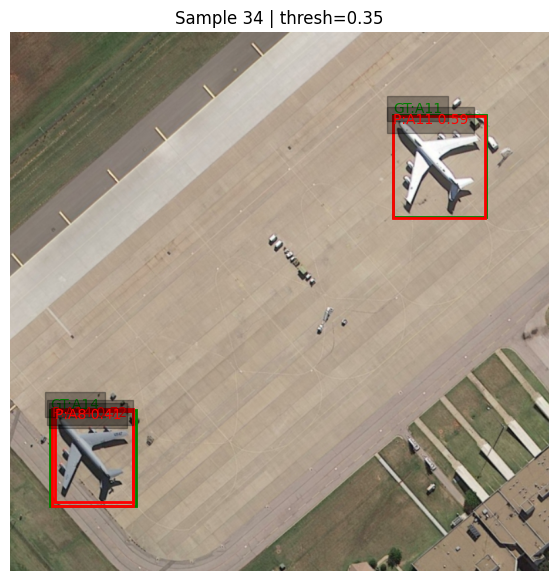

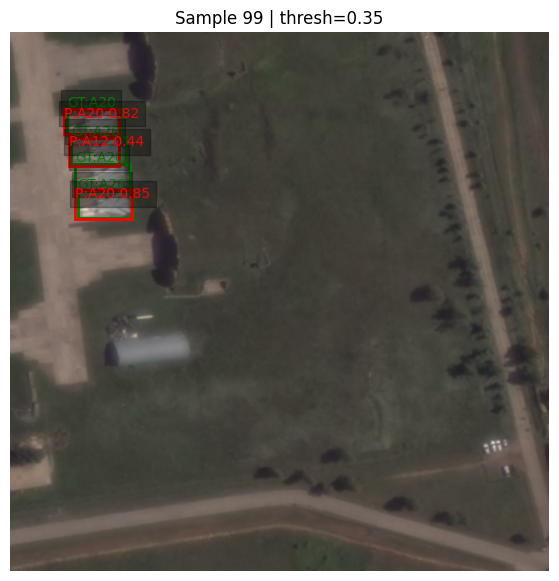

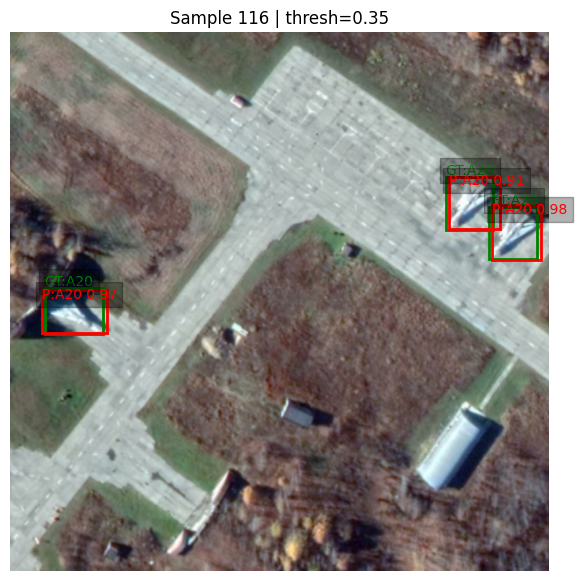

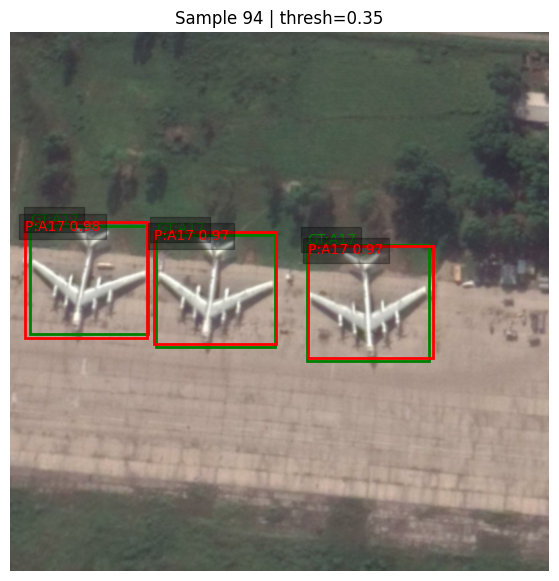

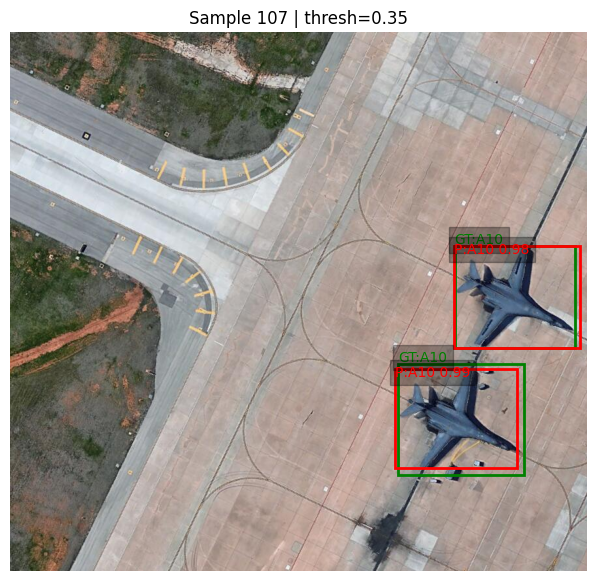

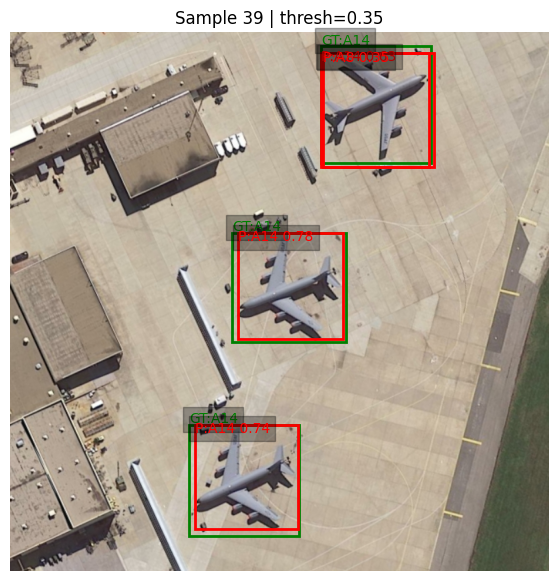

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

@torch.no_grad()
def show_preds(dataset, n=5, score_thresh=0.35):
    model.eval()
    for _ in range(n):
        i = random.randint(0, len(dataset)-1)
        img, target = dataset[i]

        pred = model([img.to(device)])[0]
        boxes_p = pred["boxes"].cpu().numpy()
        labels_p = pred["labels"].cpu().numpy()
        scores_p = pred["scores"].cpu().numpy()

        boxes_g = target["boxes"].cpu().numpy()
        labels_g = target["labels"].cpu().numpy()

        img_np = img.permute(1,2,0).cpu().numpy()

        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        ax.imshow(img_np)

        # GT (green)
        for (x1,y1,x2,y2), lab in zip(boxes_g, labels_g):
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="g", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, max(0,y1-3), f"GT:{idx_to_class.get(int(lab), lab)}", color="g", fontsize=10, bbox=dict(facecolor="black", alpha=0.3))

        # Pred (red)
        for (x1,y1,x2,y2), lab, sc in zip(boxes_p, labels_p, scores_p):
            if sc < score_thresh:
                continue
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1+12, f"P:{idx_to_class.get(int(lab), lab)} {sc:.2f}", color="r", fontsize=10, bbox=dict(facecolor="black", alpha=0.3))

        ax.set_title(f"Sample {i} | thresh={score_thresh}")
        ax.axis("off")
        plt.show()

show_preds(test_ds, n=6, score_thresh=0.35)



In [ ]:
!pip -q install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.8 MB/s eta 0:00:00


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch

@torch.no_grad()
def evaluate_map(model, loader, device, score_thresh=0.0):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")

    for images, targets in loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        preds = []
        gts = []
        for out, tgt in zip(outputs, targets):
            # preds
            boxes = out["boxes"].detach().cpu()
            scores = out["scores"].detach().cpu()
            labels = out["labels"].detach().cpu()

            if score_thresh > 0:
                keep = scores >= score_thresh
                boxes = boxes[keep]
                scores = scores[keep]
                labels = labels[keep]

            preds.append({"boxes": boxes, "scores": scores, "labels": labels})

            # gts
            gts.append({
                "boxes": tgt["boxes"].cpu(),
                "labels": tgt["labels"].cpu()
            })

        metric.update(preds, gts)

    return metric.compute()

map_res = evaluate_map(model, test_loader, device, score_thresh=0.05)
map_res


{'map': tensor(0.6746),
 'map_50': tensor(0.8741),
 'map_75': tensor(0.8468),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.6490),
 'map_large': tensor(0.6595),
 'mar_1': tensor(0.2151),
 'mar_10': tensor(0.7674),
 'mar_100': tensor(0.7954),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.7528),
 'mar_large': tensor(0.8084),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20], dtype=torch.int32)}

In [ ]:
for k,v in map_res.items():
    try:
        print(k, float(v))
    except:
        print(k, v)


map 0.6746349334716797
map_50 0.8740819692611694
map_75 0.8467795848846436
map_small -1.0
map_medium 0.6490064859390259
map_large 0.6595444083213806
mar_1 0.21507351100444794
mar_10 0.7673549652099609
mar_100 0.7953588962554932
mar_small -1.0
mar_medium 0.752842903137207
mar_large 0.8084337711334229
map_per_class -1.0
mar_100_per_class -1.0
classes tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20], dtype=torch.int32)


In [ ]:
import os

PROJECT_DIR = "/content/drive/MyDrive/ia_projet"

print("Files in ia_projet:")
for f in os.listdir(PROJECT_DIR):
    print(" -", f)



Files in ia_projet:
 - student-dataset.zip
 - archives
 - models
 - scripts
 - outputs
 - reports
 - data
 - military-aircraft-recognition-dataset.eval.zip
 - experiments
 - best_classif_resnet18_xml.pth


In [ ]:
import os, zipfile

PROJECT_DIR = "/content/drive/MyDrive/ia_projet"
TEACHER_ZIP = os.path.join(PROJECT_DIR, "military-aircraft-recognition-dataset.eval.zip")

TEACHER_EXTRACT = "/content/teacher_eval"
os.makedirs(TEACHER_EXTRACT, exist_ok=True)

assert os.path.exists(TEACHER_ZIP), f"Zip not found: {TEACHER_ZIP}"

with zipfile.ZipFile(TEACHER_ZIP, "r") as z:
    z.extractall(TEACHER_EXTRACT)

print("Extracted to:", TEACHER_EXTRACT)
print("Top-level:", os.listdir(TEACHER_EXTRACT))



Extracted to: /content/teacher_eval
Top-level: ['eval-dataset', '__MACOSX']


In [ ]:
import os, glob

def find_images_dir(root):
    best = None
    best_count = 0
    for dirpath, dirnames, filenames in os.walk(root):
        c = sum(f.lower().endswith((".jpg",".jpeg",".png")) for f in filenames)
        if c > best_count:
            best_count = c
            best = dirpath
    return best, best_count

TEACHER_IMG_DIR, nimgs = find_images_dir(TEACHER_EXTRACT)
print("TEACHER_IMG_DIR:", TEACHER_IMG_DIR)
print("Images found:", nimgs)

assert TEACHER_IMG_DIR is not None and nimgs > 0, "No images found after unzip."


TEACHER_IMG_DIR: /content/teacher_eval/eval-dataset/images
Images found: 2511


In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_PATH = "/content/best_faster_rcnn_raw.pth"
assert os.path.exists(BEST_PATH), f"Model not found: {BEST_PATH} (did training run in this runtime?)"

ckpt = torch.load(BEST_PATH, map_location=device)
classes = ckpt["classes"]
class_to_idx = ckpt["class_to_idx"]
idx_to_class = {v:k for k,v in class_to_idx.items()}
num_classes = len(classes) + 1

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
in_feat = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)

model.load_state_dict(ckpt["model"])
model.to(device)
model.eval()

print("Loaded Faster R-CNN. num_classes:", num_classes)
print("Classes:", classes)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 268MB/s]


Loaded Faster R-CNN. num_classes: 21
Classes: ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']


In [ ]:
import json
import numpy as np
from PIL import Image
import torchvision.transforms as T

to_tensor = T.ToTensor()

SCORE_THRESH = 0.35  # tune if needed (0.25-0.50)
MAX_DETS = None      # or 200 if you want

def clamp(v, lo, hi):
    return max(lo, min(int(round(v)), hi))

teacher_imgs = sorted(
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpeg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.png"))
)

print("Running inference on:", len(teacher_imgs), "images")

predictions = {}

with torch.no_grad():
    for img_path in teacher_imgs:
        name = os.path.basename(img_path)

        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        x = to_tensor(img).to(device)

        out = model([x])[0]
        boxes = out["boxes"].cpu().numpy()
        labels = out["labels"].cpu().numpy()
        scores = out["scores"].cpu().numpy()

        keep = scores >= SCORE_THRESH
        boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

        if MAX_DETS is not None and len(scores) > MAX_DETS:
            order = np.argsort(-scores)[:MAX_DETS]
            boxes, labels, scores = boxes[order], labels[order], scores[order]

        dets = []
        for (x1,y1,x2,y2), lab in zip(boxes, labels):
            cls = idx_to_class.get(int(lab))
            if cls is None:
                continue
            dets.append({
                "class": cls,
                "coordinates": {
                    "xmin": clamp(x1, 0, w-1),
                    "ymin": clamp(y1, 0, h-1),
                    "xmax": clamp(x2, 0, w-1),
                    "ymax": clamp(y2, 0, h-1),
                }
            })

        predictions[name] = dets

print("Example key:", next(iter(predictions.keys())))
print("Example detections:", predictions[next(iter(predictions.keys()))][:2])


Running inference on: 2511 images
Example key: 1.jpg
Example detections: [{'class': 'A3', 'coordinates': {'xmin': 483, 'ymin': 430, 'xmax': 548, 'ymax': 503}}, {'class': 'A10', 'coordinates': {'xmin': 62, 'ymin': 206, 'xmax': 132, 'ymax': 282}}]


In [ ]:
OUT_JSON = os.path.join(PROJECT_DIR, "outputs", "teacher_predictions.json")
os.makedirs(os.path.dirname(OUT_JSON), exist_ok=True)

with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(predictions, f, indent=2)

print("Saved:", OUT_JSON)


Saved: /content/drive/MyDrive/ia_projet/outputs/teacher_predictions.json


On commence par recharger le meilleur modèle Faster R-CNN sauvegardé, puis on récupère la liste des classes et la correspondance classe–indice afin de garder une cohérence parfaite entre l’entraînement et l’inférence. On place ensuite le modèle en mode évaluation pour réaliser des prédictions.

Nous affichons d’abord quelques exemples de résultats sur le jeu de test : on superpose les boîtes “vérité terrain” et les boîtes prédites, en filtrant les prédictions selon un seuil de confiance. Cela nous permet de vérifier visuellement si le modèle détecte correctement les objets, et de comprendre rapidement les erreurs typiques (boîtes décalées, faux positifs, objets manqués).

Ensuite, on évalue quantitativement le modèle à l’aide de la métrique mAP (mean Average Precision), qui est une référence en détection d’objets. On compare les prédictions aux annotations réelles en tenant compte du recouvrement des boîtes (IoU), puis on affiche les scores obtenus pour juger la qualité globale du détecteur.

On vérifie ensuite le contenu du dossier du projet sur Drive, puis on extrait l’archive du jeu d’images fourni pour l’évaluation externe. Nous recherchons automatiquement le dossier qui contient le plus grand nombre d’images afin d’identifier le bon répertoire, même si l’organisation exacte varie.

Nous rechargeons alors le modèle (sans poids pré-entraînés externes, uniquement nos poids entraînés), puis on lance l’inférence sur toutes les images du jeu d’évaluation. On filtre les détections avec un seuil de score, et on ajuste les coordonnées pour qu’elles restent dans les limites de l’image. Enfin, nous construisons un dictionnaire de prédictions au format attendu (nom d’image → liste de détections), puis on enregistre le résultat dans un fichier JSON dans le dossier outputs du projet.

Cette étape permet de produire automatiquement un fichier de sortie exploitable pour une évaluation par un enseignant ou une plateforme, tout en gardant un pipeline complet : chargement du modèle, contrôle qualitatif, métriques, inférence et export.

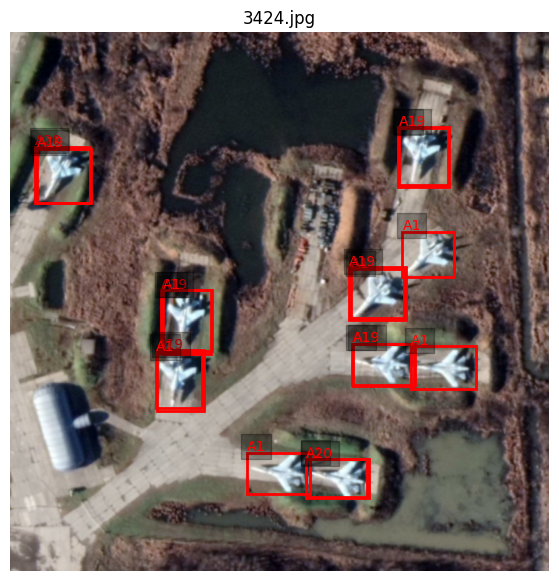

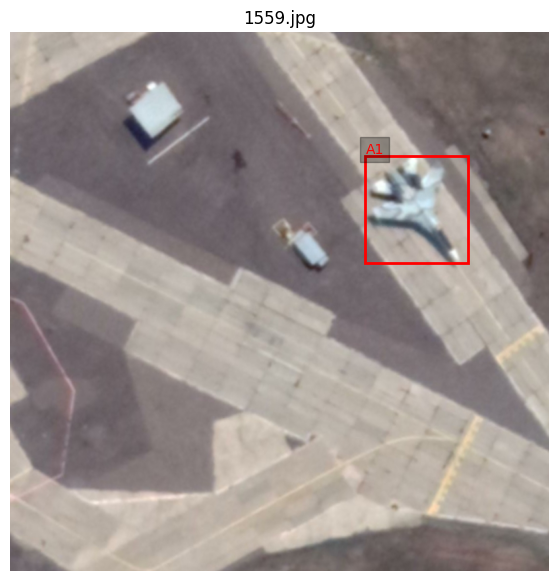

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def show_two(score_thresh=SCORE_THRESH):
    sample = random.sample(teacher_imgs, 2)
    for img_path in sample:
        name = os.path.basename(img_path)
        img = Image.open(img_path).convert("RGB")
        fig, ax = plt.subplots(1,1, figsize=(10,7))
        ax.imshow(img)
        for d in predictions[name][:30]:
            c = d["coordinates"]
            x1,y1,x2,y2 = c["xmin"], c["ymin"], c["xmax"], c["ymax"]
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, max(0,y1-3), d["class"], color="r", fontsize=10, bbox=dict(facecolor="black", alpha=0.3))
        ax.set_title(name)
        ax.axis("off")
        plt.show()

show_two()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_PATH = "/content/best_faster_rcnn_raw.pth"
ckpt = torch.load(BEST_PATH, map_location=device)

classes = ckpt["classes"]
class_to_idx = ckpt["class_to_idx"]
idx_to_class = {v:k for k,v in class_to_idx.items()}
num_classes = len(classes) + 1

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
in_feat = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feat, num_classes)

model.load_state_dict(ckpt["model"])
model.to(device)
model.eval()

print("Model reloaded")


Model reloaded


In [ ]:
import glob

TEACHER_EXTRACT = "/content/teacher_eval"

def find_images_dir(root):
    best, n = None, 0
    for d,_,f in os.walk(root):
        c = sum(x.lower().endswith((".jpg",".png",".jpeg")) for x in f)
        if c > n:
            best, n = d, c
    return best

TEACHER_IMG_DIR = find_images_dir(TEACHER_EXTRACT)
teacher_imgs = sorted(
    glob.glob(os.path.join(TEACHER_IMG_DIR,"*.jpg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR,"*.png"))
)

print("Teacher images:", len(teacher_imgs))


Teacher images: 2511


In [ ]:
SCORE_THRESH = 0.50     # 🔥 reduce false positives
NMS_THRESH   = 0.40     # 🔥 remove duplicate boxes
MAX_DETS     = 100

model.roi_heads.nms_thresh = NMS_THRESH


In [ ]:
import json
from PIL import Image
import torchvision.transforms as T
import numpy as np

to_tensor = T.ToTensor()

def clamp(v, lo, hi):
    return max(lo, min(int(round(v)), hi))

predictions = {}

with torch.no_grad():
    for p in teacher_imgs:
        name = os.path.basename(p)
        img = Image.open(p).convert("RGB")
        w,h = img.size
        x = to_tensor(img).to(device)

        out = model([x])[0]
        boxes = out["boxes"].cpu().numpy()
        labels = out["labels"].cpu().numpy()
        scores = out["scores"].cpu().numpy()

        keep = scores >= SCORE_THRESH
        boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

        if len(scores) > MAX_DETS:
            idx = np.argsort(-scores)[:MAX_DETS]
            boxes, labels = boxes[idx], labels[idx]

        dets = []
        for (x1,y1,x2,y2), lab in zip(boxes, labels):
            dets.append({
                "class": idx_to_class[int(lab)],
                "coordinates":{
                    "xmin": clamp(x1,0,w-1),
                    "ymin": clamp(y1,0,h-1),
                    "xmax": clamp(x2,0,w-1),
                    "ymax": clamp(y2,0,h-1),
                }
            })

        predictions[name] = dets


In [ ]:
OUT = "/content/drive/MyDrive/ia_projet/outputs/teacher_predictions_v2.json"

with open(OUT,"w") as f:
    json.dump(predictions, f, indent=2)

print("Saved:", OUT)


Saved: /content/drive/MyDrive/ia_projet/outputs/teacher_predictions_v2.json


On recharge le modèle Faster R-CNN entraîné afin de repartir d’un état propre et identique à celui utilisé pour l’inférence. Nous récupérons à nouveau les classes et la correspondance classe–indice pour garantir que les étiquettes prédites restent cohérentes.

On identifie ensuite automatiquement le dossier contenant les images du jeu d’évaluation enseignant, puis on reconstruit la liste complète des images à traiter.

Nous ajustons alors deux paramètres importants pour améliorer la qualité des prédictions :

On augmente le seuil de confiance (SCORE_THRESH) afin de réduire les faux positifs, c’est-à-dire les détections trop incertaines.

On règle le seuil de NMS (NMS_THRESH) afin de supprimer les boîtes redondantes qui se chevauchent fortement et représentent souvent le même objet détecté plusieurs fois.

On relance ensuite l’inférence sur toutes les images du jeu enseignant. On filtre les détections selon le seuil de score, on limite éventuellement le nombre maximal de boîtes par image, puis on convertit les coordonnées au format attendu en s’assurant qu’elles restent dans les limites de l’image.

Nous sauvegardons enfin les résultats dans un nouveau fichier JSON (teacher_predictions_v2.json) afin de conserver cette version “améliorée” séparément.

Pour terminer, on effectue une vérification qualitative : on sélectionne deux images au hasard et on affiche les boîtes prédites en rouge. Cette visualisation nous permet de juger rapidement si les réglages (seuil de score et NMS) réduisent effectivement les détections inutiles tout en conservant les objets pertinents.

In [ ]:
import torch
import torchvision
import torch.nn as nn

CLS_PATH = "/content/drive/MyDrive/ia_projet/best_classif_resnet18_xml.pth"
ckpt_cls = torch.load(CLS_PATH, map_location=device)

# This is the CRITICAL part
assert "class_to_idx" in ckpt_cls, "Checkpoint missing class_to_idx"
cls_class_to_idx = ckpt_cls["class_to_idx"]
cls_idx_to_class = {v:k for k,v in cls_class_to_idx.items()}
cls_num_classes = len(cls_class_to_idx)

print("Classifier classes:", cls_num_classes)
print("Example mapping:", list(cls_idx_to_class.items())[:5])

classifier = torchvision.models.resnet18(weights=None)
classifier.fc = nn.Linear(classifier.fc.in_features, cls_num_classes)

classifier.load_state_dict(ckpt_cls["model_state_dict"])
classifier.to(device)
classifier.eval()

print("Classifier loaded correctly")


NameError: name 'device' is not defined

In [ ]:
import os, glob, random
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
from PIL import Image

RAW_ROOT = "/content/drive/MyDrive/ia_projet/data/raw"
IMAGES_DIR = os.path.join(RAW_ROOT, "images")
ANN_DIR    = os.path.join(RAW_ROOT, "annotations")

img_files = sorted(glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
                   glob.glob(os.path.join(IMAGES_DIR, "*.jpeg")) +
                   glob.glob(os.path.join(IMAGES_DIR, "*.png")))
xml_files = sorted(glob.glob(os.path.join(ANN_DIR, "*.xml")))

print("raw images:", len(img_files))
print("raw xml   :", len(xml_files))

def stem(p):
    return os.path.splitext(os.path.basename(p))[0]

img_map = {stem(p): p for p in img_files}
xml_map = {stem(p): p for p in xml_files}
keys = sorted(set(img_map) & set(xml_map))
print("matched pairs:", len(keys))


raw images: 1331
raw xml   : 1331
matched pairs: 1331


In [ ]:
def parse_voc_objects(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objs = []
    for obj in root.findall("object"):
        name = obj.findtext("name")
        bb = obj.find("bndbox")
        if name is None or bb is None:
            continue
        xmin = float(bb.findtext("xmin"))
        ymin = float(bb.findtext("ymin"))
        xmax = float(bb.findtext("xmax"))
        ymax = float(bb.findtext("ymax"))
        if xmax <= xmin or ymax <= ymin:
            continue
        objs.append((name.strip(), xmin, ymin, xmax, ymax))
    return objs

# collect classes
classes = set()
for k in keys:
    for name, *_ in parse_voc_objects(xml_map[k]):
        classes.add(name)
classes = sorted(classes)

class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

print("num classes:", len(classes))
print("classes:", classes)

# Build sample list: (image_key, xmin, ymin, xmax, ymax, class_idx)
samples_by_image = {}
class_counts = Counter()

for k in keys:
    objs = parse_voc_objects(xml_map[k])
    lst = []
    for name,x1,y1,x2,y2 in objs:
        ci = class_to_idx[name]
        lst.append((k, x1,y1,x2,y2, ci))
        class_counts[ci] += 1
    if lst:
        samples_by_image[k] = lst

print("images with >=1 box:", len(samples_by_image))
print("total object samples:", sum(len(v) for v in samples_by_image.values()))
print("top classes:", class_counts.most_common(5))


num classes: 20
classes: ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']
images with >=1 box: 1331
total object samples: 7870
top classes: [(7, 785), (11, 736), (5, 659), (4, 561), (0, 554)]


In [ ]:
random.seed(42)
img_keys = list(samples_by_image.keys())
random.shuffle(img_keys)

n = len(img_keys)
n_train = int(0.8*n)
n_val   = int(0.1*n)

train_img_keys = set(img_keys[:n_train])
val_img_keys   = set(img_keys[n_train:n_train+n_val])
test_img_keys  = set(img_keys[n_train+n_val:])

def collect_samples(img_key_set):
    out = []
    for k in img_key_set:
        out.extend(samples_by_image[k])
    return out

train_samples = collect_samples(train_img_keys)
val_samples   = collect_samples(val_img_keys)
test_samples  = collect_samples(test_img_keys)

print("train images:", len(train_img_keys), "samples:", len(train_samples))
print("val   images:", len(val_img_keys),   "samples:", len(val_samples))
print("test  images:", len(test_img_keys),  "samples:", len(test_samples))


train images: 1064 samples: 6220
val   images: 133 samples: 876
test  images: 134 samples: 774


In [ ]:
import random, numpy as np, torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True


In [ ]:
import torchvision.transforms as T

train_tf = T.Compose([
    T.Resize((256,256)),
    T.RandomResizedCrop(224, scale=(0.75, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.2,0.2,0.15,0.02)], p=0.7),
    T.RandomGrayscale(p=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
import random
import torch
from torch.utils.data import Dataset
from PIL import Image

class CropDataset(Dataset):
    def __init__(self, samples, img_map, transform=None, jitter=0.0):
        """
        samples: list of (stem, xmin, ymin, xmax, ymax, class_idx)  [6 items]
        img_map: dict {stem: image_path}
        """
        self.samples = samples
        self.img_map = img_map
        self.transform = transform
        self.jitter = jitter

    def __len__(self):
        return len(self.samples)

    def _jitter_box(self, xmin, ymin, xmax, ymax, w, h):
        if self.jitter <= 0:
            return xmin, ymin, xmax, ymax

        bw = xmax - xmin
        bh = ymax - ymin
        jx = int(bw * self.jitter)
        jy = int(bh * self.jitter)

        xmin2 = max(0, int(xmin + random.randint(-jx, jx)))
        ymin2 = max(0, int(ymin + random.randint(-jy, jy)))
        xmax2 = min(w, int(xmax + random.randint(-jx, jx)))
        ymax2 = min(h, int(ymax + random.randint(-jy, jy)))

        # if jitter makes it invalid, fallback to original
        if xmax2 <= xmin2 or ymax2 <= ymin2:
            xmin2, ymin2, xmax2, ymax2 = int(xmin), int(ymin), int(xmax), int(ymax)

        return xmin2, ymin2, xmax2, ymax2

    def __getitem__(self, idx):
        stem, xmin, ymin, xmax, ymax, cls_idx = self.samples[idx]
        img_path = self.img_map[stem]

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        xmin, ymin, xmax, ymax = self._jitter_box(xmin, ymin, xmax, ymax, w, h)

        # clamp safely
        xmin = max(0, min(xmin, w-1))
        ymin = max(0, min(ymin, h-1))
        xmax = max(0, min(xmax, w))
        ymax = max(0, min(ymax, h))

        if xmax <= xmin or ymax <= ymin:
            # extremely rare, fallback to 1x1 crop
            xmax = min(w, xmin + 1)
            ymax = min(h, ymin + 1)

        crop = img.crop((xmin, ymin, xmax, ymax))

        if self.transform:
            crop = self.transform(crop)

        return crop, torch.tensor(cls_idx, dtype=torch.long)


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

train_ds = CropDataset(train_samples, img_map, transform=train_tf, jitter=0.10)
val_ds   = CropDataset(val_samples,   img_map, transform=eval_tf,  jitter=0.00)
test_ds  = CropDataset(test_samples,  img_map, transform=eval_tf,  jitter=0.00)

y_train = [ci for *_, ci in train_samples]
counts = Counter(y_train)
weights = torch.tensor([1.0 / counts[ci] for ci in y_train], dtype=torch.float)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=64, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("train/val/test samples:", len(train_ds), len(val_ds), len(test_ds))
print("min class count:", min(counts.values()), "max:", max(counts.values()))


train/val/test samples: 6220 876 774
min class count: 95 max: 627


In [ ]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)

clf = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze backbone first
for p in clf.parameters():
    p.requires_grad = False

clf.fc = nn.Linear(clf.fc.in_features, num_classes)  # head is trainable
clf.to(device)

print("Trainable params initially:", sum(p.requires_grad for p in clf.parameters()))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


Trainable params initially: 2


In [ ]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

label_smoothing = 0.10
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, clf.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

EPOCHS = 20
FREEZE_EPOCHS = 2        # train only the head for 2 epochs
PATIENCE = 4             # early stopping patience
BEST_CLS = "/content/best_crop_classifier_resnet50.pth"

scaler = GradScaler()

def make_scheduler(optimizer, total_epochs):
    # cosine decay, stable
    return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

scheduler = make_scheduler(optimizer, EPOCHS)


/tmp/ipython-input-4167430517.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


/tmp/ipython-input-934241385.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-934241385.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


epoch 01/20 | lr 2.98e-04 | train loss 2.6284 acc 0.3622 | val loss 2.4336 acc 0.4075
  saved best -> /content/best_crop_classifier_resnet50.pth
epoch 02/20 | lr 2.93e-04 | train loss 2.1853 acc 0.5688 | val loss 2.1052 acc 0.6221
  saved best -> /content/best_crop_classifier_resnet50.pth
Unfroze backbone. Switched LR to 1e-4
epoch 03/20 | lr 9.92e-05 | train loss 1.1746 acc 0.8415 | val loss 0.8571 acc 0.9247
  saved best -> /content/best_crop_classifier_resnet50.pth
epoch 04/20 | lr 9.70e-05 | train loss 0.7494 acc 0.9645 | val loss 0.7536 acc 0.9475
  saved best -> /content/best_crop_classifier_resnet50.pth
epoch 05/20 | lr 9.33e-05 | train loss 0.6765 acc 0.9831 | val loss 0.6961 acc 0.9658
  saved best -> /content/best_crop_classifier_resnet50.pth
epoch 06/20 | lr 8.83e-05 | train loss 0.6519 acc 0.9875 | val loss 0.6808 acc 0.9715
  saved best -> /content/best_crop_classifier_resnet50.pth
epoch 07/20 | lr 8.21e-05 | train loss 0.6310 acc 0.9934 | val loss 0.6806 acc 0.9669
  no i

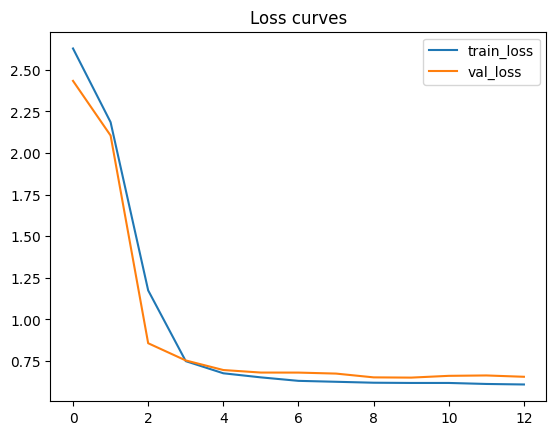

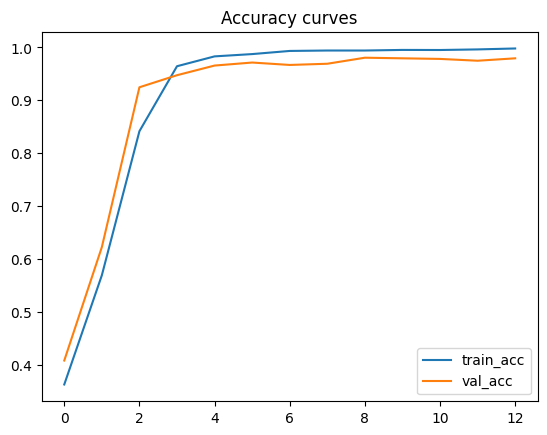

Best val acc: 0.980593607305936


In [ ]:
import math
import matplotlib.pyplot as plt

def evaluate(loader):
    clf.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            with autocast():
                logits = clf(x)
                loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)
    return total_loss/total, correct/total

train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = -1.0
bad_epochs = 0

for epoch in range(1, EPOCHS+1):
    # Unfreeze after FREEZE_EPOCHS
    if epoch == FREEZE_EPOCHS + 1:
        for p in clf.parameters():
            p.requires_grad = True
        optimizer = optim.AdamW(clf.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = make_scheduler(optimizer, EPOCHS - epoch + 1)
        print("Unfroze backbone. Switched LR to 1e-4")

    clf.train()
    total_loss, correct, total = 0.0, 0, 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = clf(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    tr_loss = total_loss/total
    tr_acc = correct/total

    va_loss, va_acc = evaluate(val_loader)

    scheduler.step()

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc); val_accs.append(va_acc)

    lr = optimizer.param_groups[0]["lr"]
    print(f"epoch {epoch:02d}/{EPOCHS} | lr {lr:.2e} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

    # Save best
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad_epochs = 0
        torch.save({
            "model_state_dict": clf.state_dict(),
            "classes": classes,
            "class_to_idx": class_to_idx
        }, BEST_CLS)
        print("  saved best ->", BEST_CLS)
    else:
        bad_epochs += 1
        print("  no improvement | bad epochs:", bad_epochs)

    # Early stopping
    if bad_epochs >= PATIENCE:
        print("Early stopping triggered.")
        break

# Plot curves
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()

plt.figure()
plt.plot(train_accs, label="train_acc")
plt.plot(val_accs, label="val_acc")
plt.legend()
plt.title("Accuracy curves")
plt.show()

print("Best val acc:", best_val_acc)


In [ ]:
from google.colab import drive
import os
import torch

drive.mount("/content/drive")

SAVE_DIR = "/content/drive/MyDrive/ia_projet/FINAL_DELIVERABLE/models"
os.makedirs(SAVE_DIR, exist_ok=True)

DET_PATH = os.path.join(SAVE_DIR, "best_faster_rcnn_raw.pth")

torch.save({
    "model_state_dict": detector.state_dict(),
    "num_classes": detector.roi_heads.box_predictor.cls_score.out_features
}, DET_PATH)

print("✅ Detector saved to Drive:")
print(DET_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'detector' is not defined

On commence par recharger un classifieur sauvegardé (ResNet-18) en s’assurant que le checkpoint contient bien la correspondance class_to_idx. Cette étape est essentielle car elle garantit que les indices de classes utilisés à l’inférence correspondent exactement à ceux utilisés pendant l’entraînement. Nous reconstruisons ensuite le modèle, nous chargeons ses poids, puis on le met en mode évaluation.

Ensuite, on recharge les données brutes : on récupère les images et leurs annotations XML (format Pascal VOC), puis on associe chaque image à son fichier XML grâce au nom de fichier (sans extension). On ne conserve que les paires valides afin de travailler sur un jeu de données cohérent.

Nous définissons une fonction qui extrait, pour chaque fichier XML, la liste des objets annotés ainsi que leurs boîtes englobantes. À partir de ces annotations, on construit la liste des classes présentes et on crée une correspondance classe–indice exploitable numériquement.

On transforme ensuite le problème en classification sur des crops : pour chaque boîte englobante, on crée un exemple d’apprentissage correspondant au recadrage de l’objet dans l’image, associé à son label. On obtient ainsi un grand ensemble d’exemples “objet recadré → classe”, tout en conservant la structure par image.

On réalise ensuite un découpage entraînement/validation/test au niveau des images (et non au niveau des crops) pour éviter que des objets provenant d’une même image se retrouvent à la fois en entraînement et en test, ce qui fausserait l’évaluation. Nous fixons aussi des graines aléatoires pour garantir des résultats reproductibles.

Pour améliorer la robustesse du modèle, on applique des transformations de data augmentation sur le jeu d’entraînement (recadrage aléatoire, flip horizontal, jitter de couleur, conversion en niveaux de gris), ainsi qu’une normalisation standard adaptée aux modèles pré-entraînés. Pour la validation et le test, on applique uniquement des transformations déterministes afin de mesurer la performance réelle.

Nous définissons un Dataset personnalisé qui recadre automatiquement l’objet selon la boîte englobante, avec la possibilité d’ajouter un léger jitter sur les coordonnées pour rendre l’apprentissage plus robuste aux imprécisions d’annotation. On contrôle aussi soigneusement les bornes pour éviter des crops invalides.

Comme certaines classes peuvent être sous-représentées, on met en place un échantillonnage pondéré (WeightedRandomSampler) afin d’équilibrer l’entraînement : on donne plus souvent des exemples des classes rares, ce qui limite le biais du modèle vers les classes majoritaires.

On initialise ensuite un modèle de classification plus puissant (ResNet-50 pré-entraîné). On commence par geler toutes les couches afin d’entraîner uniquement la tête de classification, puis on dégele progressivement tout le réseau pour faire du fine-tuning avec un taux d’apprentissage plus faible. Cette stratégie permet d’adapter efficacement le modèle à notre dataset tout en conservant les représentations générales apprises.

Nous utilisons une perte CrossEntropyLoss avec label smoothing pour réduire l’excès de confiance et améliorer la généralisation. On entraîne avec AdamW, un scheduler de type cosinus pour stabiliser l’apprentissage, et on active l’entraînement en précision mixte (autocast + GradScaler) afin d’accélérer les calculs sur GPU et réduire l’usage mémoire.

À chaque époque, on évalue les performances sur la validation, on sauvegarde automatiquement le meilleur modèle, et on applique un early stopping afin d’arrêter l’entraînement si la performance ne s’améliore plus. Enfin, on trace les courbes de perte et de précision pour visualiser la convergence et diagnostiquer un éventuel surapprentissage.

In [ ]:
import os
import random
import torch
from torch.utils.data import Dataset
from PIL import Image

class CropDataset(Dataset):
    def __init__(self, samples, img_map, transform=None, jitter=0.0):
        """
        samples: list of (stem, xmin, ymin, xmax, ymax, class_idx)  [6 items]
        img_map: dict {stem: image_path}
        """
        self.samples = samples
        self.img_map = img_map
        self.transform = transform
        self.jitter = jitter

    def __len__(self):
        return len(self.samples)

    def _jitter_box(self, xmin, ymin, xmax, ymax, w, h):
        if self.jitter <= 0:
            return xmin, ymin, xmax, ymax

        bw = xmax - xmin
        bh = ymax - ymin
        jx = int(bw * self.jitter)
        jy = int(bh * self.jitter)

        xmin2 = max(0, int(xmin + random.randint(-jx, jx)))
        ymin2 = max(0, int(ymin + random.randint(-jy, jy)))
        xmax2 = min(w, int(xmax + random.randint(-jx, jx)))
        ymax2 = min(h, int(ymax + random.randint(-jy, jy)))

        # if jitter makes it invalid, fallback to original
        if xmax2 <= xmin2 or ymax2 <= ymin2:
            xmin2, ymin2, xmax2, ymax2 = int(xmin), int(ymin), int(xmax), int(ymax)

        return xmin2, ymin2, xmax2, ymax2

    def __getitem__(self, idx):
        stem, xmin, ymin, xmax, ymax, cls_idx = self.samples[idx]
        img_path = self.img_map[stem]

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        xmin, ymin, xmax, ymax = self._jitter_box(xmin, ymin, xmax, ymax, w, h)

        # clamp safely
        xmin = max(0, min(xmin, w-1))
        ymin = max(0, min(ymin, h-1))
        xmax = max(0, min(xmax, w))
        ymax = max(0, min(ymax, h))

        if xmax <= xmin or ymax <= ymin:
            # extremely rare, fallback to 1x1 crop
            xmax = min(w, xmin + 1)
            ymax = min(h, ymin + 1)

        crop = img.crop((xmin, ymin, xmax, ymax))

        if self.transform:
            crop = self.transform(crop)

        return crop, torch.tensor(cls_idx, dtype=torch.long)


In [ ]:
TEACHER_EXTRACT = "/content/teacher_eval"

def find_images_dir(root):
    best, best_count = None, 0
    for dirpath, _, filenames in os.walk(root):
        c = sum(f.lower().endswith((".jpg",".jpeg",".png")) for f in filenames)
        if c > best_count:
            best_count = c
            best = dirpath
    return best, best_count

TEACHER_IMG_DIR, nimgs = find_images_dir(TEACHER_EXTRACT)
print("Teacher images dir:", TEACHER_IMG_DIR, "| images:", nimgs)

teacher_imgs = sorted(
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpeg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.png"))
)

print("Teacher files:", len(teacher_imgs))
print("First 5:", [os.path.basename(p) for p in teacher_imgs[:5]])
assert len(teacher_imgs) > 0


Teacher images dir: None | images: 0


NameError: name 'glob' is not defined

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_CLS = "/content/best_crop_classifier_resnet50.pth"
assert os.path.exists(BEST_CLS), f"Missing classifier checkpoint: {BEST_CLS}"

ckpt_cls = torch.load(BEST_CLS, map_location=device)

cls_classes = ckpt_cls["classes"]
cls_class_to_idx = ckpt_cls["class_to_idx"]
cls_idx_to_class = {v:k for k,v in cls_class_to_idx.items()}
num_cls = len(cls_classes)

clf_best = models.resnet50(weights=None)
clf_best.fc = nn.Linear(clf_best.fc.in_features, num_cls)
clf_best.load_state_dict(ckpt_cls["model_state_dict"])
clf_best.to(device)
clf_best.eval()

print("Classifier ready.")
print("num classes:", num_cls)
print("example mapping:", list(cls_idx_to_class.items())[:5])


AssertionError: Missing classifier checkpoint: /content/best_crop_classifier_resnet50.pth

In [ ]:
to_tensor_det = T.ToTensor()

cls_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

DET_THRESH = 0.50
NMS_THRESH = 0.40
PAD = 0.05
MAX_DETS = 100

detector.roi_heads.nms_thresh = NMS_THRESH

def clamp_int(v, lo, hi):
    return max(lo, min(int(round(v)), hi))

def pad_box(x1,y1,x2,y2,w,h,pad=0.05):
    bw = x2-x1
    bh = y2-y1
    x1 = max(0, x1 - pad*bw)
    y1 = max(0, y1 - pad*bh)
    x2 = min(w-1, x2 + pad*bw)
    y2 = min(h-1, y2 + pad*bh)
    return x1,y1,x2,y2

predictions = {}

with torch.no_grad():
    for img_path in teacher_imgs:
        name = os.path.basename(img_path)
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        out = detector([to_tensor_det(img).to(device)])[0]
        boxes = out["boxes"].cpu().numpy()
        scores = out["scores"].cpu().numpy()

        keep = scores >= DET_THRESH
        boxes = boxes[keep]
        scores = scores[keep]

        if len(scores) > MAX_DETS:
            order = np.argsort(-scores)[:MAX_DETS]
            boxes = boxes[order]
            scores = scores[order]

        dets = []
        for (x1,y1,x2,y2) in boxes:
            x1,y1,x2,y2 = pad_box(x1,y1,x2,y2,w,h,PAD)
            xi1, yi1 = clamp_int(x1,0,w-1), clamp_int(y1,0,h-1)
            xi2, yi2 = clamp_int(x2,0,w-1), clamp_int(y2,0,h-1)
            if xi2 <= xi1 or yi2 <= yi1:
                continue

            crop = img.crop((xi1, yi1, xi2, yi2))
            x = cls_tf(crop).unsqueeze(0).to(device)
            pred_idx = int(torch.argmax(clf_best(x), dim=1).item())
            cls_name = cls_idx_to_class[pred_idx]

            dets.append({
                "class": cls_name,
                "coordinates": {"xmin": xi1, "ymin": yi1, "xmax": xi2, "ymax": yi2}
            })

        predictions[name] = dets

print("Done. Example:", next(iter(predictions.keys())), "->", len(next(iter(predictions.values()))), "detections")


Done. Example: 1.jpg -> 3 detections


In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/ia_projet"
OUT_JSON = os.path.join(PROJECT_DIR, "outputs", "teacher_predictions_2stage_FINAL.json")
os.makedirs(os.path.dirname(OUT_JSON), exist_ok=True)

with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(predictions, f, indent=2)

print("Saved:", OUT_JSON)


Saved: /content/drive/MyDrive/ia_projet/outputs/teacher_predictions_2stage_FINAL.json


On met en place un pipeline complet qui combine détection d’objets et classification fine. L’idée est de d’abord repérer où se trouvent les objets dans l’image, puis de reconnaître précisément leur type à partir d’un recadrage propre.

Nous définissons d’abord une classe CropDataset qui permet de construire un jeu de données à partir de boîtes englobantes : pour chaque annotation, on recadre l’objet dans l’image et on associe ce recadrage à sa classe. On peut également ajouter un léger jitter sur les coordonnées des boîtes pour rendre l’apprentissage plus robuste aux imprécisions d’annotation. On sécurise ensuite les coordonnées en les bornant aux dimensions de l’image afin d’éviter des crops invalides.

On localise ensuite automatiquement le dossier contenant les images de l’évaluation enseignant (en choisissant le répertoire qui contient le plus grand nombre d’images), puis on liste tous les fichiers à traiter. Cela permet de rester robuste même si la structure du zip n’est pas exactement celle attendue.

Nous rechargeons ensuite le meilleur classifieur entraîné sur des recadrages d’objets (ResNet-50). On reconstruit le modèle avec exactement le même nombre de classes et on recharge les poids du checkpoint. On récupère aussi la correspondance class_to_idx afin d’obtenir un nom de classe correct à partir d’un indice prédit.

On définit ensuite les transformations appliquées aux recadrages avant classification : redimensionnement, conversion en tenseur et normalisation standard, ce qui garantit que les entrées du classifieur ont le même format que pendant l’entraînement.

Pour la partie détection, on fixe des seuils importants : un seuil de confiance pour limiter les faux positifs, un seuil de NMS pour supprimer les boîtes redondantes, et un nombre maximal de détections par image pour éviter des sorties trop chargées. On ajoute aussi un petit padding autour de chaque boîte détectée afin de mieux capturer l’objet complet lorsque la boîte est légèrement trop serrée.

Ensuite, on exécute le pipeline sur chaque image :

on applique le détecteur pour produire des boîtes candidates,

on filtre les boîtes selon le score et on applique les limites (NMS + max détections),

on recadre l’image sur chaque boîte (avec padding),

on passe chaque crop dans le classifieur pour prédire la classe finale,

on enregistre la prédiction au format attendu (classe + coordonnées).

Enfin, on exporte toutes les prédictions dans un fichier JSON sur Google Drive. Cette approche “deux étapes” permet généralement d’obtenir des classes plus fiables, car la classification est faite directement sur l’objet recadré plutôt que sur l’image entière.

In [ ]:
print([k for k in globals().keys() if "clf" in k.lower() or "class" in k.lower()])
print([k for k in globals().keys() if "det" in k.lower() or "rcnn" in k.lower()])


[]
[]


In [ ]:
import os
import glob
import json
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image


CLASSIFIER_PATH = "/content/drive/MyDrive/ia_projet/FINAL_DELIVERABLE/models/best_crop_classifier_resnet50.pth"
DETECTOR_PATH   = "/content/drive/MyDrive/ia_projet/FINAL_DELIVERABLE/models/best_faster_rcnn_raw.pth"

TEACHER_EXTRACT = "/content/teacher_eval"
PROJECT_DIR = "/content/drive/MyDrive/ia_projet"
OUT_JSON = os.path.join(PROJECT_DIR, "outputs", "teacher_predictions_2stage_FINAL.json")
os.makedirs(os.path.dirname(OUT_JSON), exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def find_images_dir(root):
    best, best_count = None, 0
    for dirpath, _, filenames in os.walk(root):
        c = sum(f.lower().endswith((".jpg", ".jpeg", ".png")) for f in filenames)
        if c > best_count:
            best_count = c
            best = dirpath
    return best, best_count


def clamp_int(v, lo, hi):
    return max(lo, min(int(round(v)), hi))


def pad_box(x1, y1, x2, y2, w, h, pad=0.05):
    bw = x2 - x1
    bh = y2 - y1
    x1 = max(0, x1 - pad * bw)
    y1 = max(0, y1 - pad * bh)
    x2 = min(w - 1, x2 + pad * bw)
    y2 = min(h - 1, y2 + pad * bh)
    return x1, y1, x2, y2


def _unwrap_state_dict(ckpt):
    if isinstance(ckpt, dict):
        for k in ["model_state_dict", "state_dict", "model"]:
            if k in ckpt and isinstance(ckpt[k], dict):
                return ckpt[k]
    return ckpt


assert os.path.exists(CLASSIFIER_PATH), f"Missing classifier checkpoint: {CLASSIFIER_PATH}"
assert os.path.exists(DETECTOR_PATH), f"Missing detector checkpoint: {DETECTOR_PATH}"


TEACHER_IMG_DIR, nimgs = find_images_dir(TEACHER_EXTRACT)
print("Teacher images dir:", TEACHER_IMG_DIR, "| images:", nimgs)

teacher_imgs = sorted(
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpeg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.png"))
)
print("Teacher files:", len(teacher_imgs))
print("First 5:", [os.path.basename(p) for p in teacher_imgs[:5]])
assert len(teacher_imgs) > 0, "No images found."


ckpt_cls = torch.load(CLASSIFIER_PATH, map_location=device)

cls_classes = ckpt_cls["classes"]
cls_class_to_idx = ckpt_cls["class_to_idx"]
cls_idx_to_class = {v: k for k, v in cls_class_to_idx.items()}
num_cls = len(cls_classes)

clf_best = models.resnet50(weights=None)
clf_best.fc = nn.Linear(clf_best.fc.in_features, num_cls)
clf_best.load_state_dict(_unwrap_state_dict(ckpt_cls))
clf_best.to(device).eval()

print("Classifier ready.")
print("num classes:", num_cls)
print("example mapping:", list(cls_idx_to_class.items())[:5])


ckpt_det = torch.load(DETECTOR_PATH, map_location=device)
sd_det = _unwrap_state_dict(ckpt_det)

detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
missing, unexpected = detector.load_state_dict(sd_det, strict=False)
detector.to(device).eval()

print("Detector ready.")
print("Missing keys:", len(missing), "| Unexpected keys:", len(unexpected))


to_tensor_det = T.ToTensor()

cls_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

DET_THRESH = 0.50
NMS_THRESH = 0.40
PAD = 0.05
MAX_DETS = 100

if hasattr(detector, "roi_heads") and hasattr(detector.roi_heads, "nms_thresh"):
    detector.roi_heads.nms_thresh = NMS_THRESH


predictions = {}

with torch.no_grad():
    for img_path in teacher_imgs:
        name = os.path.basename(img_path)
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        out = detector([to_tensor_det(img).to(device)])[0]
        boxes = out["boxes"].detach().cpu().numpy()
        scores = out["scores"].detach().cpu().numpy()

        keep = scores >= DET_THRESH
        boxes = boxes[keep]
        scores = scores[keep]

        if len(scores) > MAX_DETS:
            order = np.argsort(-scores)[:MAX_DETS]
            boxes = boxes[order]
            scores = scores[order]

        dets = []
        for (x1, y1, x2, y2) in boxes:
            x1, y1, x2, y2 = pad_box(x1, y1, x2, y2, w, h, PAD)
            xi1, yi1 = clamp_int(x1, 0, w - 1), clamp_int(y1, 0, h - 1)
            xi2, yi2 = clamp_int(x2, 0, w - 1), clamp_int(y2, 0, h - 1)

            if xi2 <= xi1 or yi2 <= yi1:
                continue

            crop = img.crop((xi1, yi1, xi2, yi2))
            x = cls_tf(crop).unsqueeze(0).to(device)
            pred_idx = int(torch.argmax(clf_best(x), dim=1).item())
            cls_name = cls_idx_to_class[pred_idx]

            dets.append({
                "class": cls_name,
                "coordinates": {"xmin": xi1, "ymin": yi1, "xmax": xi2, "ymax": yi2}
            })

        predictions[name] = dets

print("Done. Example:", next(iter(predictions.keys())), "->", len(next(iter(predictions.values()))), "detections")


with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(predictions, f, indent=2)

print("Saved:", OUT_JSON)


Teacher images dir: None | images: 0


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
import os

for root, dirs, files in os.walk("/content/teacher_eval"):
    print(root, "->", len(files), "files")
    print(files[:5])


In [ ]:
import glob # Import the glob module
import os # Import the os module (good practice for os.path.join)

TEACHER_IMG_DIR = "/content/teacher_eval/eval-dataset/images" # Corrected path

teacher_imgs = sorted(
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.jpeg")) +
    glob.glob(os.path.join(TEACHER_IMG_DIR, "*.png"))
)

print("Teacher files:", len(teacher_imgs))
assert len(teacher_imgs) > 0

Teacher files: 0


AssertionError: 